Installing libraries and stuff

In [73]:
!pip install geopandas;
!pip install folium matplotlib mapclassify;

import geopandas as gpd;
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Read in Election Preceint Data

In [74]:
shape = gpd.read_file("/content/ga_vest_20.zip")

data = shape.to_crs(4326)

data['lon'] = data.centroid.x  
data['lat'] = data.centroid.y

<ipython-input-74-8f9a58015b58>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['lon'] = data.centroid.x
<ipython-input-74-8f9a58015b58>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data['lat'] = data.centroid.y


In [75]:
# Get column names
print(data.keys())


Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS',
       'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA', 'geometry',
       'lon', 'lat'],
      dtype='object')


In [79]:
# Create a new dataframe that maps each precinct code to the total population
population = data.groupby('PRECINCT_I')[['G20PREDBID', 'G20PRERTRU', 'G20PRELJOR']].sum().sum(axis=1).reset_index()
population.columns = ['PRECINCT_I', 'POP']

# Merge the population data into the main data
data = data.merge(population, on='PRECINCT_I')

print(population)


     PRECINCT_I   POP
0          0001  6463
1          0002  7968
2          0003  1639
3          0004  1384
4          0005   965
...         ...   ...
1698         WN  2567
1699       WOOD  2275
1700         WS  1949
1701         YA  1362
1702      YONKE   184

[1703 rows x 2 columns]


In [81]:
print(data.keys())
print(data.POP)


Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'R21USSRPER', 'R21USSDOSS',
       'R21USSRLOE', 'R21USSDWAR', 'R21PSCRMCD', 'R21PSCDBLA', 'geometry',
       'lon', 'lat', 'POP'],
      dtype='object')
0        4924
1        4924
2       10623
3       10623
4       10623
        ...  
2667      333
2668      176
2669     1258
2670     3338
2671     3667
Name: POP, Length: 2672, dtype: int64


ML k means 💀

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


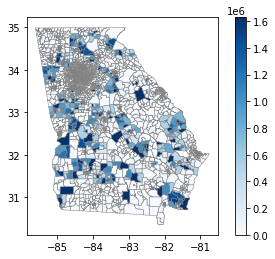

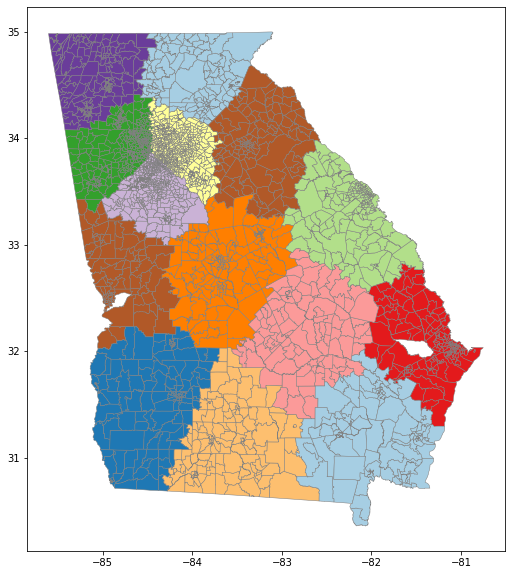

10.075634717941284


In [95]:
from locale import D_T_FMT
from sys import builtin_module_names
import pandas as pd
from random import randint
from random import random
import math
import time
from sklearn.cluster import KMeans
import geopandas as gpd

def kmeans_grouping(df, num_groups):
    # Create a dataframe with the latitude and longitude columns
    coords = data[['lat', 'lon']]

    # Use KMeans to cluster the precincts into 10 groups
    kmeans = KMeans(num_groups, random_state=42).fit(coords)

    # Add the cluster labels to the original dataframe
    data['District Number'] = kmeans.labels_ + 1

    # Repair the geometry using buffer(0)
    gdf = shape
    gdf.geometry = gdf.geometry.buffer(0)

    # Merge the precinct data with the district data
    districts = data.dissolve(by='PRECINCT_I', aggfunc='sum')

    # Plot the districts
    districts.plot(column='POP', cmap='Blues', edgecolor='grey', linewidth=0.5, legend=True)

    # Add a new column with the cluster/group number assigned by KMeans
    data['Group'] = kmeans.labels_

    # Create a choropleth map using the 'Group' column as the color
    fig, ax = plt.subplots(figsize=(10, 10))
    data.plot(column='Group', cmap='Paired', linewidth=0.5, edgecolor='grey', ax=ax)
    ax.axis('on')
    plt.show()



start_time = time.time()
redistrict = kmeans_grouping(data, 14)
print(time.time()-start_time)


adjacency ordering

In [ ]:
from locale import D_T_FMT
from sys import builtin_module_names
import pandas as pd
from random import randint
from random import random
import math
import time

def adjacency_grouping(df, num_groups):
    origin = df.sample(n=1)
    df['District Number'] = 0
    df['Distance to Origin'] = 0

    # Find distance of each precinct to the origin
    for i in range(len(df)):
        lon = df.loc[i, 'lon']
        lat = df.loc[i, 'lat']
        distance = math.sqrt((lon - origin['lon'])**2 + (lat - origin['lat'])**2)
        df.loc[i, 'Distance to Origin'] = distance

    # Sort precincts by distance to origin
    df = df.sort_values(by=['Distance to Origin'])

    # Assign each precinct to a group
    group_size = len(df) // num_groups
    for i in range(num_groups):
        start_index = i * group_size
        end_index = (i + 1) * group_size
        if i == num_groups - 1:
            end_index = len(df)
        group = df.iloc[start_index:end_index]
        group_num = i + 1
        group['District Number'] = group_num
        df.iloc[start_index:end_index] = group

    fig, ax = plt.subplots(figsize=(10,10))

    # Plot the precincts
    redistrict.plot(column='District Number', cmap='Set3', linewidth=0.5, ax=ax, edgecolor='black')

    # Add title and remove axes
    ax.set_title('Redistricting Map')
    ax.set_axis_off()

    plt.show()

    # Convert to geopandas dataframe
    gdf = gpd.GeoDataFrame(redistrict, geometry='geometry')

    # Plot the districts
    gdf.plot(column='District Number', figsize=(12, 8))

    return df


start_time = time.time()
redistrict = adjacency_grouping(data, 10)
print(time.time()-start_time)


makes maps with population ordering

In [ ]:
from locale import D_T_FMT
from sys import builtin_module_names
import pandas as pd
from random import randint
from random import random
import math
import time

def population_grouping(df, num_groups):
    # Sort precincts by population in decreasing order
    df_sorted = df.sort_values(by='POP_x', ascending=False)
    
    # Initialize empty list of groups
    groups = [[] for i in range(num_groups)]
    
    # Iterate through each precinct and add it to the group with the smallest total population that is currently below 750000
    for i in range(len(df_sorted)):
        precinct = df_sorted.iloc[i]
        min_group_idx = None
        min_group_pop = float('inf')
        for j in range(num_groups):
            group_pop = sum([p['POP_x'] for p in groups[j]])
            if group_pop < 750000 and group_pop < min_group_pop:
                min_group_idx = j
                min_group_pop = group_pop
        if min_group_idx is not None:
            groups[min_group_idx].append(precinct.to_dict())
        else:
            # If no group exists that satisfies the above condition, create a new group and add the precinct to that group
            groups.append([precinct.to_dict()])
    
    # Convert list of groups back to dataframe
    group_dfs = []
    for i in range(num_groups):
        group_df = pd.DataFrame(groups[i])
        group_df['District Number'] = i + 1
        group_df['Distance to Origin'] = 0
        group_dfs.append(group_df)

    # Convert to geopandas dataframe
    gdf = gpd.GeoDataFrame(redistrict, geometry='geometry')

    # Plot the districts
    gdf.plot(column='District Number', figsize=(12, 8))

    return pd.concat(group_dfs)


start_time = time.time()
redistrict = population_grouping(data, 10)
print(time.time()-start_time)


Makes maps with distance function

In [ ]:
from locale import D_T_FMT
from sys import builtin_module_names
import pandas as pd
from random import randint
from random import random
import math
import time

def population_grouping(df, num_groups):
  origin = df.sample(n=1)
  df['District Number'] = 0
  df['Distance to Origin'] = 0

  # Find distance of each precinct to the origin
  for i in range(len(df)):
    lon = df.loc[i, 'lon']
    lat = df.loc[i, 'lat']
    distance = math.sqrt((lon - origin.iloc[0]['lon'])**2 + (lat - origin.iloc[0]['lat'])**2)
    df.loc[i, 'Distance to Origin'] = distance

  # Sort precincts by distance to origin
  df = df.sort_values(by=['Distance to Origin'])

  # Assign each precinct to a group
  group_size = len(df) // num_groups
  for i in range(num_groups):
    start_index = i * group_size
    end_index = (i + 1) * group_size
    if i == num_groups - 1:
      end_index = len(df)
    group = df.iloc[start_index:end_index]
    group_num = i + 1
    group['District Number'] = group_num
    df.iloc[start_index:end_index] = group

    # Convert to geopandas dataframe
    gdf = gpd.GeoDataFrame(redistrict, geometry='geometry')

    # Plot the districts
    gdf.plot(column='District Number', figsize=(12, 8))

  return df

start_time = time.time()
redistrict = population_grouping(data, 10)
print(time.time()-start_time)


other method

In [ ]:
from locale import D_T_FMT
from sys import builtin_module_names
import pandas as pd
from random import randint
from random import random
import math
import time

def population_grouping(df, districts, step = 0.05, placement='precinct'):
  df['District Number'] = 0
  df['G20VR'] = 0

  #calculates the registered voters as an approximation of population
  for x in range(len(df.iloc[:, 0])):
    df.loc[x, 'G20VR'] = (df.loc[x, 'G20PRERTRU'] + df.loc[x, 'G20PREDBID'] + df.loc[x, 'G20PRELJOR'])

  #whats the threshold for this state (population/districts)
  threshold = sum(df.loc[:, 'G20VR'])/districts
  #print(sum(df.loc[:, 'G20VR']), threshold)
  gap = 0
  counter = 0
  new_df = pd.DataFrame()
  pop_list = []
  lon_centers = []
  lat_centers = []
  index_list = []

  #option control. I tried to make it random by latitude and longitude but it doesn't work. Use "precinct" in the arguments
  if placement == "precinct":
    for n in range(districts):
      num = random()
      lon_centers.append(df.loc[round(num*len(df.iloc[:, 0])), 'lon'])
      lat_centers.append(df.loc[round(num*len(df.iloc[:, 0])), 'lat'])
      pop_list.append(df.loc[round(num*len(df.iloc[:, 0])), 'G20VR'])
      df.loc[round(num*len(df.iloc[:, 0])), "District Number"] = n+1
      index_list.append(round(num*len(df.iloc[:, 0])))
    new_df = df.iloc[index_list, :]
    df = df.drop(index_list)
    df = df.reset_index(drop=True)
  elif placement == "latlong":
    lon_min, lon_max, lat_min, lat_max = min(df.loc[:, 'lon']), max(df.loc[:, 'lon']), min(df.loc[:, 'lat']), max(df.loc[:, "lat"])
    for n in range(districts):
      num = random()
      lon_centers.append((lon_max-lon_min)*num+lon_min)
      lat_centers.append((lat_max-lat_min)*num+lat_min)
      print((lon_max-lon_min)*num+lon_min, (lat_max-lat_min)*num+lat_min)
      pop_list = [0] * districts
  
  checker=1

  #iterative step. continues until checker is 0 (which is when all precincts are assigned)
  while checker != 0:
    index_list = []
    for n in range(len(lon_centers)):
      if pop_list[n] > 0.98*threshold:
        #print("passing ...", pop_list[n], threshold)
        #print(sum(pop_list))
        pass
      else:
        for x in range(len(df.iloc[:, 0])):
          if math.sqrt(pow(df.loc[x, 'lon']-lon_centers[n], 2) + pow(df.loc[x, 'lat']-lat_centers[n], 2)) < gap and df.loc[x, "District Number"] == 0:
            df.loc[x, "District Number"] = n+1
            pop_list[n] += df.loc[x, 'G20VR']
            index_list.append(x)
          elif gap > 5:
            pass
            #print(math.sqrt(pow(df.loc[x, 'lon']-lon_centers[n], 2) + pow(df.loc[x, 'lat']-lat_centers[n], 2)))
    
    gap += step
    
    #print(gap)
    checker = 0
    for x in range(len(df.loc[:, "District Number"])):
      if df.loc[x, "District Number"] == 0:
        checker += 1
    
    new_df = pd.concat([new_df, df.iloc[index_list, :]])

    
    df = df.drop(index_list)
    df = df.reset_index(drop=True)
    #print(checker)
    #print(len(df.iloc[:, 1]))
    #print(df)

    counter += 1
    #saves figures
    if (counter % 10 == 0):
      redistrict = new_df
      redistrict.reset_index(inplace=True, drop=True)
      
      fig, ax = plt.subplots(1, 1, figsize=(15, 15))
      redistrict.plot("District Number", ax=ax, cmap="tab20")
      #plt.savefig('arkansas' + str(gap) + '.png')

  return new_df

start_time = time.time()
redistrict = population_grouping(data, 10)
print(time.time()-start_time)


Simulation

In [63]:
a = redistrict.groupby("District Number").sum();
a = a[['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR']]

b, t = 0, 0;

for d in a.index:
  if a.loc[d, 'G20PREDBID'] > a.loc[d, 'G20PRERTRU']:
    b += 1
  else:
    t += 1

print("D: ", b, " R: ", t)

AttributeError: ignored